# Import Libraries

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import zipfile

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.pipeline import Pipeline
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

# Import Data

In [2]:
#load data 
with zipfile.ZipFile('concrete+compressive+strength.zip') as z:
    with z.open('Concrete_Data.xls') as f:
        data = pd.read_excel(f)

In [3]:
#drop duplicates
data = data.drop_duplicates()

In [4]:
data.columns = ['Cement', 'Blast_Furnace_Slag', 'Fly_Ash',
                'Water', 'Superplasticizer', 'Coarse_Aggregate',
                'Fine_Aggregate', 'Age (Days)', 'Compressive_Strength (MPa)']

In [6]:
#make function to calculate total
def get_percentages(dataframe):
    my_kg = dataframe.iloc[:, :-1].sum(axis=1)
    my_copy = dataframe.copy()
    my_copy.iloc[:, :-2] = dataframe.iloc[:, :-2].div(my_kg, axis=0) * 100
    return my_copy

#get df of percentage of value per total
percentage_df = get_percentages(data)
percentage_df

,Cement,Blast_Furnace_Slag,Fly_Ash,Water,Superplasticizer,Coarse_Aggregate,Fine_Aggregate,Age (Days),Compressive_Strength (MPa)
0,22.054319,0.000000,0.000000,6.616296,0.102103,42.474985,27.608740,28,79.986111
1,21.920032,0.000000,0.000000,6.576010,0.101482,42.825249,27.440633,28,61.887366
2,13.305322,5.702281,0.000000,9.123649,0.000000,37.294918,23.769508,270,40.269535
3,12.818042,5.493446,0.000000,8.789514,0.000000,35.929067,22.898998,365,41.052780
4,7.391418,4.927612,0.000000,7.145781,0.000000,36.413711,30.723138,360,44.296075
...,...,...,...,...,...,...,...,...,...
1025,11.824093,4.962355,3.862936,7.683094,0.380732,37.221937,32.867043,28,44.284354
1026,13.987410,0.000000,5.018450,8.508791,0.451487,35.506837,35.311483,28,31.178794
1027,6.468615,6.072222,4.730583,8.393954,0.265714,38.872675,33.976565,28,23.696601
1028,6.801471,7.981361,0.000000,7.506840,0.483071,42.305062,33.725205,28,32.768036


In [5]:
#functions to declare and split data

def declare_var(dataframe, target):
    X = dataframe.drop(target, axis=1)
    y = dataframe[target]
    return X, y

def split_data(X_var, y_var, testing_size):
    X_train, X_test, y_train, y_split = train_test_split(X_var, y_var, test_size=testing_size, shuffle=True)
    return X_train, X_test, y_train, y_split

def print_cross_scores(scores):
    for i in range(len(scores)):
        print(f"Fold {i+1}: ", '{:.4f}'.format(scores[i]))


#eval model
def eval_model(actual_data, predict_data, training=bool):
    r2 = r2_score(actual_data, predict_data)
    mad = mean_absolute_error(actual_data, predict_data)
    mse = mean_squared_error(actual_data, predict_data)
    root_mse = np.sqrt(mse)
    if training == True:
        print("Training data metrics:")
        print("R2: ", r2 )
        print("MAD: ", mad)
        print("RMSE: ", root_mse)
    elif training == False:
        print("Testing data metrics:")
        print("R2: ", r2 )
        print("MAD: ", mad)
        print("RMSE: ", root_mse)
    else:
        return "Declare training parameter to True or False."     

In [7]:
#declare var and split data for raw data
X, y = declare_var(data, 'Compressive_Strength (MPa)')

X_train, X_test, y_train, y_test = split_data(X, y, 0.3)

In [8]:
#delcar var and split data for precentage_df
X_percent, y_percent = declare_var(percentage_df, 'Compressive_Strength (MPa)')

percent_train, percent_test, target_train, target_test = split_data(X_percent, y_percent, 0.3)

# Linear Regression

## Base model

In [26]:
#pipeline
pipeline = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('linear_regression', LinearRegression())
])

In [13]:
#fit data
pipeline.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('linear_regression', LinearRegression())])

In [19]:
#cross val scores for raw data
raw_scores = cross_val_score(pipeline, X_train, y_train, cv=5)

print_cross_scores(raw_scores)

Fold 1:  0.5407
Fold 2:  0.6401
Fold 3:  0.5989
Fold 4:  0.5898
Fold 5:  0.5609


In [27]:
#fit pipeline on percent data
pipeline.fit(percent_train, target_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('linear_regression', LinearRegression())])

In [28]:
#cross val scores for percentage _df
percent_scores = cross_val_score(pipeline, percent_train, target_train)
print_cross_scores(percent_scores)

Fold 1:  0.6077
Fold 2:  0.5920
Fold 3:  0.6957
Fold 4:  0.6960
Fold 5:  0.7432


Well the base model does not have great cross validation scores for the raw data, but it does perform better on the percentage_df. There was no normalization either, so the poor results are warranted here

# Random Forest

In [26]:
pipeline = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('rf', RandomForestRegressor())
])

In [10]:
#fit pipeline on raw data
pipeline.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()), ('rf', RandomForestRegressor())])

In [11]:
raw_scores = cross_val_score(pipeline, X_train, y_train, cv=5)
print_cross_scores(raw_scores)

Fold 1:  0.8485
Fold 2:  0.8999
Fold 3:  0.8682
Fold 4:  0.9013
Fold 5:  0.8968


In [12]:
#get predictions
train_predict = pipeline.predict(X_train)
test_predict = pipeline.predict(X_test)

In [13]:
#train model results
eval_model(y_train, train_predict, training=True)

Training data metrics:
R2:  0.9846757225417981
MAD:  1.4111169114660809
RMSE:  1.9971731636176269


In [14]:
#eval model test data
eval_model(y_test, test_predict, training=False)

Testing data metrics:
R2:  0.9104592066792175
MAD:  3.577351271595
RMSE:  4.968765721929266


Check feature importance then rerun

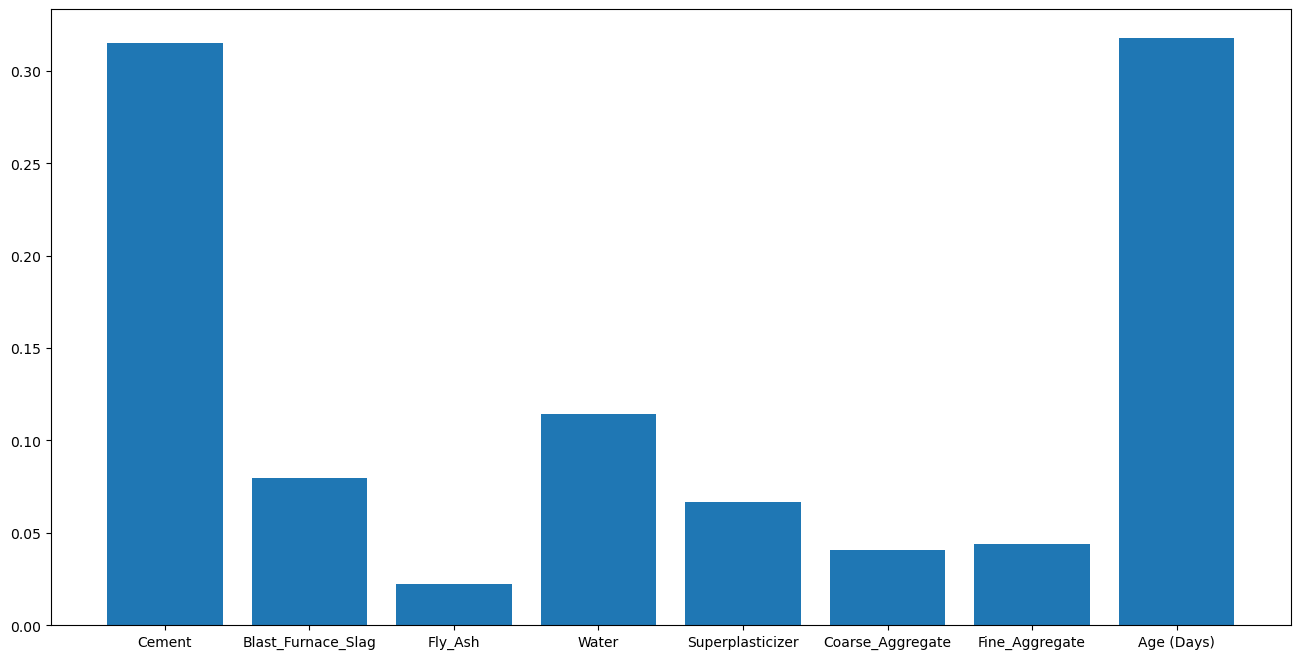

In [18]:
#feature importance
rf_model = pipeline.named_steps['rf']

feature_importance = rf_model.feature_importances_

feature_names = list(X_train.columns)

fig = plt.figure(figsize=(16, 8))
plt.bar(feature_names, feature_importance)
plt.show()

Cement and Age appear to account for over 30% each with water accounting for about 13%

## rf with percentage data

Ignore below for now

In [19]:
#fit pipeline on percent data
pipeline.fit(percent_train, target_train)

Pipeline(steps=[('scaler', StandardScaler()), ('rf', RandomForestRegressor())])

In [20]:
#cross val scores
percent_scores = cross_val_score(pipeline, percent_train, target_train, cv=5)
print_cross_scores(percent_scores)

Fold 1:  0.8689
Fold 2:  0.8437
Fold 3:  0.8915
Fold 4:  0.8782
Fold 5:  0.8239


In [21]:
# get predictions
train_pred = pipeline.predict(percent_train)
test_pred = pipeline.predict(percent_test)

In [22]:
# eval model on train data
eval_model(target_train, train_pred, training=True)

Training data metrics:
R2:  0.9831089239416391
MAD:  1.5174281744894853
RMSE:  2.090192224810544


In [23]:
#eval model on test data
eval_model(target_test, test_pred, training=False)

Testing data metrics:
R2:  0.9049938975929402
MAD:  3.7094249658790694
RMSE:  5.138584993008958


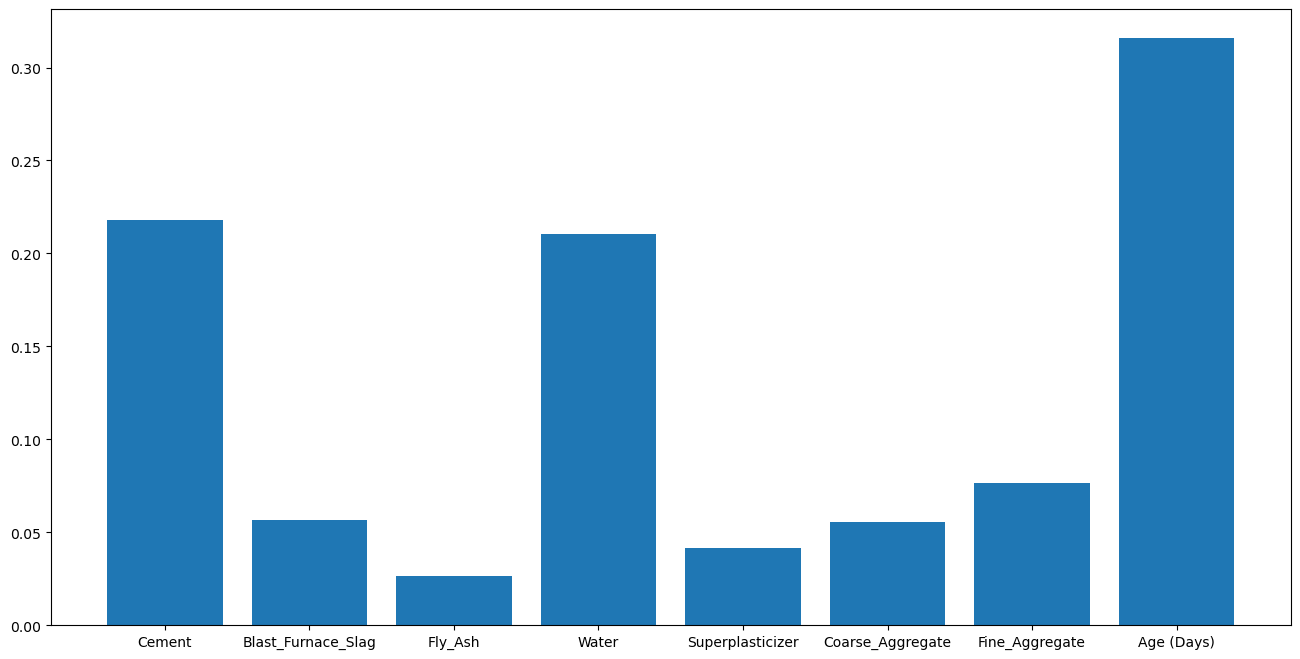

In [24]:
#check feature importance
feature_importance = rf_model.feature_importances_

fig = plt.figure(figsize=(16, 8))
plt.bar(feature_names, feature_importance)
plt.show()

Interestingly Age is the most important at over 30% while Water and Cement are ~23%

## rf with top 3 feature importance

In [25]:
#update train data
top_features = ['Cement', 'Water', 'Age (Days)']

X_train = X_train[top_features]
X_test = X_test[top_features]

percent_train = percent_train[top_features]
percent_test = percent_test[top_features]


,Cement,Blast_Furnace_Slag,Fly_Ash,Water,Superplasticizer,Coarse_Aggregate,Fine_Aggregate,Age (Days)
701,288.00,192.0,0.00,192.00,0.00,932.0,717.8,90
989,146.50,114.6,89.30,201.90,8.80,860.0,829.5,28
535,393.00,0.0,0.00,192.00,0.00,940.6,785.6,90
145,469.00,117.2,0.00,137.80,32.20,852.1,840.5,56
335,275.07,0.0,121.35,159.48,9.90,1053.6,777.5,14
...,...,...,...,...,...,...,...,...
444,251.37,0.0,118.27,192.94,5.75,1043.6,754.3,28
665,173.00,116.0,0.00,192.00,0.00,946.8,856.8,7
637,375.00,0.0,0.00,186.00,0.00,1038.0,758.0,7
487,387.00,20.0,94.00,157.00,11.61,938.0,845.0,28


### Normal Data

In [27]:
#fit pipeline
pipeline.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()), ('rf', RandomForestRegressor())])

In [28]:
#cross val 
scores = cross_val_score(pipeline, X_train, y_train, cv=5)

print_cross_scores(scores)

Fold 1:  0.8510
Fold 2:  0.8991
Fold 3:  0.8668
Fold 4:  0.9086
Fold 5:  0.8997


In [29]:
#predictions
train_pred = pipeline.predict(X_train)
test_pred = pipeline.predict(X_test)

In [30]:
#eval model on train data
eval_model(y_train, train_pred, training=True)

Training data metrics:
R2:  0.9852052350053535
MAD:  1.3686446616546164
RMSE:  1.962364839995898


In [31]:
#eval on test data
eval_model(y_test, test_pred, training=False)

Testing data metrics:
R2:  0.9084782977501515
MAD:  3.62053380033419
RMSE:  5.023427003543404


### Percent Data

In [32]:
#percent data
pipeline.fit(percent_train, target_train)

Pipeline(steps=[('scaler', StandardScaler()), ('rf', RandomForestRegressor())])

In [33]:
#cross val 
scores = cross_val_score(pipeline, percent_train, target_train, cv=5)

print_cross_scores(scores)

Fold 1:  0.8717
Fold 2:  0.8532
Fold 3:  0.8863
Fold 4:  0.8764
Fold 5:  0.8266


In [34]:
#predictions
train_pred = pipeline.predict(percent_train)
test_pred = pipeline.predict(percent_test)

In [35]:
#eval on train data
eval_model(target_train, train_pred, training=True)

Training data metrics:
R2:  0.9827522184847992
MAD:  1.5139230070331153
RMSE:  2.1121472408947537


In [36]:
#eval model on test dta
eval_model(target_test, test_pred, training=False)

Testing data metrics:
R2:  0.9042725322439434
MAD:  3.70363404964479
RMSE:  5.158056307892131


Mhmm PCA might be calling in this case

# XGBOOST

In [17]:
#initialize pipeline
pipeline = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('xgboost', XGBRegressor())
])

In [18]:
#fit pipeline 
pipeline.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('xgboost',
                 XGBRegressor(base_score=None, booster=None, callbacks=None,
                              colsample_bylevel=None, colsample_bynode=None,
                              colsample_bytree=None, early_stopping_rounds=None,
                              enable_categorical=False, eval_metric=None,
                              feature_types=None, gamma=None, gpu_id=None,
                              grow_policy=None, importance_type=None,
                              interaction_constraints=None, learning_rate=None,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=None, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, n_estimators=100,
                              n_jobs=None, num_parallel_tree=None,
                              predictor=None, random_state=None, ...))])

In [19]:
#cross val scores
raw_scores = cross_val_score(pipeline, X_train, y_train, cv=5)

print_cross_scores(raw_scores)

Fold 1:  0.9366
Fold 2:  0.9045
Fold 3:  0.9034
Fold 4:  0.9223
Fold 5:  0.9005


In [21]:
#get predictions
train_pred = pipeline.predict(X_train)
test_pred = pipeline.predict(X_test)

In [22]:
#eval train data
eval_model(y_train, train_pred, training=True)

Training data metrics:
R2:  0.9992560465977164
MAD:  0.2749403982134118
RMSE:  0.44445072691429444


In [23]:
#eval on test data
eval_model(y_test, test_pred, training=False)

Testing data metrics:
R2:  0.898614997103699
MAD:  3.2504203363444057
RMSE:  5.166883694020705
